In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import MultipleLocator, StrMethodFormatter
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

from scipy.stats import gaussian_kde, chi2, norm

%matplotlib widget

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# plt.rc('font', size=21)
# plt.rc('xtick', labelsize=21)
# plt.rc('ytick', labelsize=21)

fig_width_pt = 244.0  # Get this from LaTeX using \the\columnwidth
text_width_pt = 508.0 # Get this from LaTeX using \the\textwidth

inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt*1.5 # width in inches
fig_width_full = text_width_pt*inches_per_pt*1.5  # 17
fig_height =fig_width*golden_mean # height in inches
fig_size = [fig_width,fig_height] #(9,5.5) #(9, 4.5)
fig_height_full = fig_width_full*golden_mean

fig_size_full = [fig_width_full,fig_height_full] #(9,5.5) #(9, 4.5)

In [3]:
def plot_2d_kde_contours(ax, x, y, levels=[0.95, 0.68], color = 'C0'):
    values = np.vstack([x, y])
    kde = gaussian_kde(values)

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(kde(positions).T, xx.shape)

    # Flatten & sort density values
    f_sorted = np.sort(f.ravel())[::-1]
    cdf = np.cumsum(f_sorted)
    cdf /= cdf[-1]

    # density thresholds corresponding to levels
    v = [f_sorted[np.searchsorted(cdf, lev)] for lev in levels]

    # filled contours: 1σ and 2σ
    cset = ax.contourf(xx, yy, f, levels=[v[1], v[0]],
                       colors=color, alpha=0.35)
    
    cset = ax.contourf(xx, yy, f, levels=[v[0], f.max()],
                       colors=color, alpha=0.7)

    ax.contour(xx, yy, f, levels=[v[1], v[0]], colors='grey', linewidths=1.2)
    
def plot_kde_map_ci(ax, data, axis='x', color='k'):
    kde = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 1001)
    pdf = kde(xs)
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]

    # MAP = mode of KDE
    map_idx = np.argmax(pdf)
    map_val = xs[map_idx]

    prob = 0.68
    widths = []
    for i in range(len(xs)):
        for j in range(i+1, len(xs)):
            p = cdf[j] - cdf[i]
            if p >= prob:
                widths.append((xs[j]-xs[i], xs[i], xs[j]))
                break
    if widths:
        best = min(widths, key=lambda t: t[0])
        low, high = best[1], best[2]
    else:
        low, high = map_val, map_val

    if axis == 'x':
        ax.axvline(map_val, color=color, linestyle='-')
        ax.axvline(low, color=color, linestyle='--', alpha=0.75)
        ax.axvline(high, color=color, linestyle='--', alpha=0.75)
    else:
        ax.axhline(map_val, color=color, linestyle='-')
        ax.axhline(low, color=color, linestyle='--', alpha=0.75)
        ax.axhline(high, color=color, linestyle='--', alpha=0.75)
    
    return map_val


In [4]:
def hpd_sigma_from_point(samples, point, weights=None, bandwidth='scott'):
    """
    Parameters
    ----------
    samples : (N,2) array of posterior draws for (H, m)
    point   : tuple/list (H1, m1)
    weights : optional length-N weights proportional to posterior weights
    bandwidth : KDE bandwidth rule ('scott', 'silverman', or float/array)

    Returns
    -------
    result : dict with keys:
      'alpha'          : HPD credible mass enclosed by contour through `point`
      'n_sigma_2d'     : 2D-Gaussian-equivalent N-sigma for that contour
      'n_sigma_1d'     : 1D-equivalent N-sigma (tail mapping)
      'map_estimate'   : KDE mode estimate (argmax over samples)
      'density_point'  : KDE density at the query point
      'density_map'    : KDE density at the mode
      'hpd_threshold'  : density threshold f* so that HPD = {f >= f(point)}
    """
    samples = np.asarray(samples)
    assert samples.shape[1] == 2, "samples must be (N,2)"
    Hm = samples.T  # shape (2, N)
    if weights is not None:
        weights = np.asarray(weights).astype(float)
        weights = np.clip(weights, 0, np.inf)
        wsum = weights.sum()
        if wsum <= 0: 
            raise ValueError("All weights are non-positive.")
        weights = weights / wsum

    # KDE fit (scipy gaussian_kde supports 'weights' and custom bandwidth method)
    kde = gaussian_kde(Hm, weights=weights, bw_method=bandwidth)

    # KDE density at each sample (for HPD ranking) and at the query point
    dens_samples = kde.evaluate(Hm)           # (N,)
    dens_point   = float(kde.evaluate(np.asarray(point).reshape(2,1))[0])

    # MAP as argmax of KDE over the samples (simple, robust)
    imap = np.argmax(dens_samples)
    map_est = samples[imap]
    dens_map = float(dens_samples[imap])

    # HPD mass α = P(f >= f(point)) estimated from samples (weighted if provided)
    if weights is None:
        alpha = np.mean(dens_samples >= dens_point)
    else:
        alpha = float(weights[dens_samples >= dens_point].sum())

    # Convert α to "Nσ"
    # 2D-Gaussian-equivalent contour: α = F_χ2(df=2)(Δχ2); Nσ_2D = sqrt(Δχ2)
    n_sigma_2d = np.sqrt(chi2.ppf(alpha, df=2))
    # 1D-equivalent: α ↦ central probability => Nσ_1D
    n_sigma_1d = norm.ppf((1.0 + alpha) / 2.0)

    return dict(alpha=alpha,
                n_sigma_2d=n_sigma_2d,
                n_sigma_1d=n_sigma_1d,
                map_estimate=map_est,
                density_point=dens_point,
                density_map=dens_map,
                hpd_threshold=dens_point)

In [5]:
def sample_sn(sn, n=50000, rng=None):
    rng = np.random.default_rng(rng)
    # Log mass: asymmetric Gaussian (piecewise sigma)
    logM_samples = np.where(
        rng.random(n) < 0.5,
        rng.normal(sn['log_M'], sn['log_M_err_l'], size=n),
        rng.normal(sn['log_M'], sn['log_M_err_u'], size=n)
    )
    # Age: asymmetric Gaussian
    age_samples = np.where(
        rng.random(n) < 0.5,
        rng.normal(sn['age'], sn['age_err_l'], size=n),
        rng.normal(sn['age'], sn['age_err_u'], size=n)
    )
    
    ssfr_samples = np.where(
        rng.random(n) < 0.5,
        rng.normal(sn['log_sSFR'], sn['log_sSFR_err_l'], size=n),
        rng.normal(sn['log_sSFR'], sn['log_sSFR_err_u'], size=n)
    )
    
    return np.vstack([logM_samples, age_samples]).T, np.vstack([logM_samples, ssfr_samples]).T

In [6]:
def tension_from_two_posteriors(
    samples1, samples2, weights1=None, weights2=None,
    n_pairs=50000, bandwidth='scott', rng=None):
    """
    Compute tension between two 2-D posteriors using HPD mass of delta=0.

    samples1, samples2 : arrays (N,2) and (M,2) of (H,m) samples
    weights1, weights2 : optional 1-D weights (nonnegative), length N and M
    n_pairs            : number of independent (i,j) pairs to draw for deltas
    bandwidth         : KDE bw for gaussian_kde ('scott', 'silverman', or float)
    rng               : np.random.Generator for reproducibility

    Returns dict with:
      alpha, n_sigma_2d, n_sigma_1d,
      density_at_zero, map_delta, density_map_delta
      alpha_gauss, n_sigma_2d_gauss, n_sigma_1d_gauss (Gaussian quick check)
    """
    rng = np.random.default_rng() if rng is None else rng
    s1 = np.asarray(samples1); s2 = np.asarray(samples2)
    assert s1.shape[1]==2 and s2.shape[1]==2, "Use 2-D samples."

    N, M = len(s1), len(s2)

    # Normalize weights if given
    if weights1 is not None:
        w1 = np.asarray(weights1, float); w1 = np.clip(w1, 0, np.inf)
        w1 /= w1.sum()
    else:
        w1 = None
    if weights2 is not None:
        w2 = np.asarray(weights2, float); w2 = np.clip(w2, 0, np.inf)
        w2 /= w2.sum()
    else:
        w2 = None

    # Draw independent indices for the convolution via random pairing
    i = rng.integers(0, N, size=n_pairs)
    j = rng.integers(0, M, size=n_pairs)

    deltas = s1[i] - s2[j]                       # shape (n_pairs, 2)
    deltas_T = deltas.T                          # (2, n_pairs)

    # Pair weights = product of marginals for independent draws
    if (w1 is None) and (w2 is None):
        w = None
    else:
        wi = (w1[i] if w1 is not None else np.full(n_pairs, 1.0/N))
        wj = (w2[j] if w2 is not None else np.full(n_pairs, 1.0/M))
        w  = wi * wj
        w /= w.sum()

    # KDE on deltas
    kde = gaussian_kde(deltas_T, weights=w, bw_method=bandwidth)
    dens_deltas = kde.evaluate(deltas_T)         # (n_pairs,)
    dens_zero   = float(kde.evaluate(np.zeros((2,1)))[0])  # at delta=(0,0)

    # MAP delta (mode among the sampled deltas)
    imap = np.argmax(dens_deltas)
    map_delta = deltas[imap]
    dens_map  = float(dens_deltas[imap])

    # HPD mass through zero: α = P(f >= f(0))
    if w is None:
        alpha = np.mean(dens_deltas >= dens_zero)
    else:
        alpha = float(w[dens_deltas >= dens_zero].sum())

    # Convert to sigma
    n_sigma_2d = np.sqrt(chi2.ppf(alpha, df=2))
    n_sigma_1d = norm.ppf((1 + alpha) / 2.0)

    # -------- Gaussian quick-check (for reference) --------
    mu1 = (s1 if w1 is None else (s1 * w1[:,None]).sum(axis=0)) if w1 is not None else s1.mean(axis=0)
    mu2 = (s2 if w2 is None else (s2 * w2[:,None]).sum(axis=0)) if w2 is not None else s2.mean(axis=0)
    C1  = np.cov(s1.T, aweights=(w1 if w1 is not None else None), bias=False)
    C2  = np.cov(s2.T, aweights=(w2 if w2 is not None else None), bias=False)
    dmu = mu1 - mu2
    Csum = C1 + C2
    # Regularize in case of near-singularity
    eps = 1e-12 * np.trace(Csum)
    Csum_reg = Csum + eps * np.eye(2)
    T2 = float(dmu @ np.linalg.solve(Csum_reg, dmu))  # Δχ² under Gaussian approx
    alpha_g = float(chi2.cdf(T2, df=2))
    n_sigma_2d_g = np.sqrt(T2)
    n_sigma_1d_g = norm.ppf((1 + alpha_g) / 2.0)

    return dict(
        alpha=alpha, n_sigma_2d=n_sigma_2d, n_sigma_1d=n_sigma_1d,
        density_at_zero=dens_zero, map_delta=map_delta, density_map_delta=dens_map,
        alpha_gauss=alpha_g, n_sigma_2d_gauss=n_sigma_2d_g, n_sigma_1d_gauss=n_sigma_1d_g
    )

In [7]:
# --- Load Schulze data (filtered for IIn and SLSN-II) ---
df = pd.read_csv('../Data/schulze_2021.csv')

df['class'] = df['class'].str.strip()  # remove any leading/trailing spaces
# df = df[df['class'].isin(['SNIIn', 'SNII'])] #, 'SLSN-IIn'
contains_string = df['class'].str.contains('IIn', case=False, regex=False)

df = df[contains_string]

# --- Extract Mass and SFR values with uncertainties ---
log_M = df['logM']
log_M_err = [df['logM_l'], df['logM_u']]
log_SFR = df['age']
log_SFR_err = [df['age_l'], df['age_u']]

sn2019vxm = {'log_M': 7.72,
             'log_M_err_u': 0.37,
             'log_M_err_l': 0.55,
             'age': 5.61,
             'age_err_u': 2.35, 
             'age_err_l': 5.16,
             'log_sSFR': -8.63,
             'log_sSFR_err_u': 0.57,
             'log_sSFR_err_l': 0.52}

In [8]:
sn_age_samples, sn_ssfr_samples = sample_sn(sn2019vxm, n=50000)

In [9]:
mask = df['class'] == 'SNIIn'
df_age_samples = np.vstack([df.loc[mask, 'logM'], df.loc[mask, 'age']]).T
df_ssfr_samples = np.vstack([df.loc[mask, 'logM'], df.loc[mask, 'logSSFR']]).T

age_iin_dict = tension_from_two_posteriors(sn_age_samples, df_age_samples, weights1=None, weights2=None, 
                                           n_pairs=50000, bandwidth='scott', rng=None)

ssfr_iin_dict = tension_from_two_posteriors(sn_ssfr_samples, df_ssfr_samples, weights1=None, weights2=None, 
                                            n_pairs=50000, bandwidth='scott', rng=None)

In [10]:
age_iin_dict

{'alpha': 0.81092,
 'n_sigma_2d': 1.8251493489887893,
 'n_sigma_1d': 1.3133055771131288,
 'density_at_zero': 0.0057015126328189645,
 'map_delta': array([-2.38392146, -0.26768982]),
 'density_map_delta': 0.0344408701634925,
 'alpha_gauss': 0.7300181885201414,
 'n_sigma_2d_gauss': 1.6182711065469166,
 'n_sigma_1d_gauss': 1.1031044433283466}

In [11]:
ssfr_iin_dict

{'alpha': 0.71698,
 'n_sigma_2d': 1.5888597876829231,
 'n_sigma_1d': 1.073559851603569,
 'density_at_zero': 0.050972262869568435,
 'map_delta': array([-2.357179  ,  1.27148435]),
 'density_map_delta': 0.19388443475806427,
 'alpha_gauss': 0.6430172813851204,
 'n_sigma_2d_gauss': 1.435317320745068,
 'n_sigma_1d_gauss': 0.9211296945341002}

In [12]:
mask = df['class'] == 'SLSN-IIn'
df_age_SL_samples = np.vstack([df.loc[mask, 'logM'], df.loc[mask, 'age']]).T
df_ssfr_SL_samples = np.vstack([df.loc[mask, 'logM'], df.loc[mask, 'logSSFR']]).T

age_sliin_dict = tension_from_two_posteriors(sn_age_samples, df_age_SL_samples, weights1=None, weights2=None, 
                                       n_pairs=50000, bandwidth='scott', rng=None)

ssfr_sliin_dict = tension_from_two_posteriors(sn_ssfr_samples, df_ssfr_SL_samples, weights1=None, weights2=None, 
                                        n_pairs=50000, bandwidth='scott', rng=None)

In [13]:
age_sliin_dict

{'alpha': 0.81144,
 'n_sigma_2d': 1.8266576145267408,
 'n_sigma_1d': 1.3148509506533321,
 'density_at_zero': 0.005338206208208978,
 'map_delta': array([-0.85135834,  4.13672633]),
 'density_map_delta': 0.040940055118416405,
 'alpha_gauss': 0.5347566894374228,
 'n_sigma_2d_gauss': 1.2370891331831206,
 'n_sigma_1d_gauss': 0.7302403039103262}

In [14]:
ssfr_sliin_dict

{'alpha': 0.62824,
 'n_sigma_2d': 1.406774178185976,
 'n_sigma_1d': 0.8931814692729791,
 'density_at_zero': 0.0659921216847094,
 'map_delta': array([-0.88924866,  0.11333585]),
 'density_map_delta': 0.1912373665212751,
 'alpha_gauss': 0.2523582612907311,
 'n_sigma_2d_gauss': 0.7626681777679739,
 'n_sigma_1d_gauss': 0.32175047128204903}

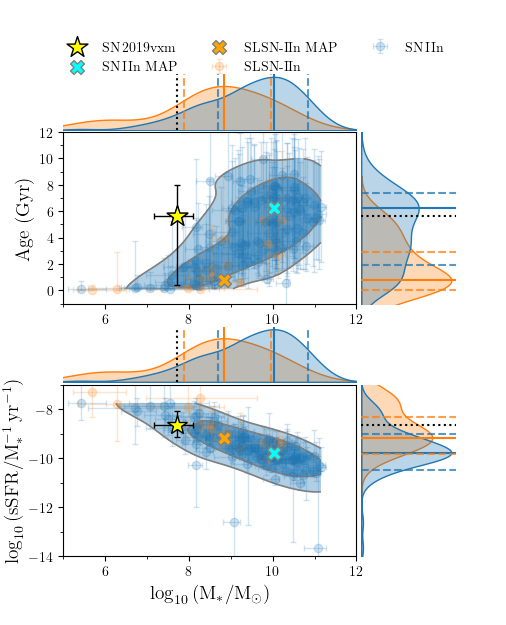

In [18]:
fig = plt.figure(figsize=(fig_size[0], fig_size[1]*2))  # double height
outer_gs = GridSpec(2, 1, hspace=0.1, figure=fig)

# =====================================================
# --- TOP PANEL: logM vs Age ---
# =====================================================
gs_top = GridSpecFromSubplotSpec(4, 4, hspace=0.03, wspace=0.05,
                                 subplot_spec=outer_gs[0])

main_ax_top = fig.add_subplot(gs_top[1:, :-1])
x_hist_top = fig.add_subplot(gs_top[0, :-1], sharex=main_ax_top)
y_hist_top = fig.add_subplot(gs_top[1:, -1], sharey=main_ax_top)

colors = {'SNIIn': 'C0', 'SLSN-IIn': 'C1', 'cSLSN-IIn': 'C2'}

# Scatter + errors (age)
for sn_class in ['SLSN-IIn','SNIIn']:
    class_mask = df['class'] == sn_class
    
    if sn_class == 'SNIIn':
        sn_label = r'SN$\,$IIn'
    else:
        sn_label = sn_class
    
    main_ax_top.errorbar(df.loc[class_mask, 'logM'],
                         df.loc[class_mask, 'age'],
                         xerr=[df.loc[class_mask, 'logM_l'], df.loc[class_mask, 'logM_u']],
                         yerr=[df.loc[class_mask, 'age_l'], df.loc[class_mask, 'age_u']],
                         fmt='o', ecolor=colors[sn_class], elinewidth=1, capsize=2,
                         label=sn_label, alpha=0.2, color=colors[sn_class])

# main_ax_top.errorbar(sn2019vxm['log_M'], sn2019vxm['age'], 
#                      xerr=[[sn2019vxm['log_M_err_l']], [sn2019vxm['log_M_err_u']]],
#                      yerr=[[sn2019vxm['age_err_l']], [sn2019vxm['age_err_u']]],
#                      fmt='*', markersize=15, color='yellow', label='SN2019vxm', zorder=10, 
#                      markeredgecolor = 'k', ecolor='k', elinewidth=1, capsize=2,)

main_ax_top.errorbar(sn2019vxm['log_M'], sn2019vxm['age'], 
                 xerr=[[sn2019vxm['log_M_err_l']], [sn2019vxm['log_M_err_u']]],
                 yerr=[[sn2019vxm['age_err_l']], [sn2019vxm['age_err_u']]],
                 fmt='*', markersize=15, color='yellow', zorder=10, 
                 markeredgecolor='k', ecolor='k', elinewidth=1, capsize=2,
                 label=None)   # no legend entry

# fake point just for legend (no errorbars)
main_ax_top.scatter(sn2019vxm['log_M'], sn2019vxm['age'],
                marker='*', s=250, color='yellow', edgecolors='k',
                label=r'SN$\,$2019vxm', zorder=11)

main_ax_top.set_ylabel(r'Age (Gyr)', fontsize=14)
main_ax_top.set_ylim(-1, 12)
main_ax_top.set_xlim(5, 12)

# Histograms
for sn_class in ['SLSN-IIn','SNIIn']:
    sns.kdeplot(df.loc[df['class'] == sn_class, 'logM'], ax=x_hist_top,
                color=colors[sn_class], fill=True, common_norm=False, alpha=0.3)
x_hist_top.axvline(sn2019vxm['log_M'], color='k', linestyle=':')
x_hist_top.axis('off')

for sn_class in ['SLSN-IIn','SNIIn']:
    sns.kdeplot(y=df.loc[df['class'] == sn_class, 'age'], ax=y_hist_top,
                color=colors[sn_class], fill=True, common_norm=False, alpha=0.3)
y_hist_top.axhline(sn2019vxm['age'], color='k', linestyle=':')
y_hist_top.axis('off')

# Contours + MAP markers
x_map_iin_top = plot_kde_map_ci(x_hist_top, df.loc[df['class']=='SNIIn','logM'], axis='x', color='C0')
y_map_iin_top = plot_kde_map_ci(y_hist_top, df.loc[df['class']=='SNIIn','age'], axis='y', color='C0')

x_map_slsn_iin_top = plot_kde_map_ci(x_hist_top, df.loc[df['class']=='SLSN-IIn','logM'], axis='x', color='C1')
y_map_slsn_iin_top = plot_kde_map_ci(y_hist_top, df.loc[df['class']=='SLSN-IIn','age'], axis='y', color='C1')

plot_2d_kde_contours(main_ax_top, df['logM'][df['class'] == 'SNIIn'],
                     df['age'][df['class'] == 'SNIIn'], levels=[0.68, 0.95])

main_ax_top.scatter(x_map_iin_top, y_map_iin_top, marker='X', color='cyan', s=100,
                    label=r'SN$\,$IIn MAP', edgecolors='gray', zorder=15)
main_ax_top.scatter(x_map_slsn_iin_top, y_map_slsn_iin_top, marker='X', color='orange', s=100,
                    label='SLSN-IIn MAP', edgecolors='gray', zorder=15)

# =====================================================
# --- BOTTOM PANEL: logM vs logSSFR ---
# =====================================================
gs_bot = GridSpecFromSubplotSpec(4, 4, hspace=0.05, wspace=0.05,
                                    subplot_spec=outer_gs[1])

main_ax_bot = fig.add_subplot(gs_bot[1:, :-1], sharex=main_ax_top)
x_hist_bot = fig.add_subplot(gs_bot[0, :-1], sharex=main_ax_bot)
y_hist_bot = fig.add_subplot(gs_bot[1:, -1], sharey=main_ax_bot)

# Scatter + errors (logSSFR)
for sn_class in ['SLSN-IIn','SNIIn']:
    class_mask = df['class'] == sn_class
    main_ax_bot.errorbar(df.loc[class_mask, 'logM'],
                         df.loc[class_mask, 'logSSFR'],
                         xerr=[df.loc[class_mask, 'logM_l'], df.loc[class_mask, 'logM_u']],
                         yerr=[df.loc[class_mask, 'logSSFR_l'], df.loc[class_mask, 'logSSFR_u']],
                         fmt='o', ecolor=colors[sn_class], elinewidth=1, capsize=2,
                         alpha=0.2, color=colors[sn_class])

main_ax_bot.set_xlabel(r'$\log_{10}^{}\,(\mathrm{M}_*/\mathrm{M}_\odot)$', fontsize=14)
main_ax_bot.set_ylabel(r'$\log_{10}^{}\,(\mathrm{sSFR}/\mathrm{M}_*^{-1}\,\mathrm{yr}^{-1})$', fontsize=14)
main_ax_bot.set_ylim(-14, -7)  # adjust if needed

# Histograms
for sn_class in ['SLSN-IIn','SNIIn']:
    sns.kdeplot(df.loc[df['class'] == sn_class, 'logM'], ax=x_hist_bot,
                color=colors[sn_class], fill=True, common_norm=False, alpha=0.3)
x_hist_bot.axvline(sn2019vxm['log_M'], color='k', linestyle=':')
x_hist_bot.axis('off')

for sn_class in ['SLSN-IIn','SNIIn']:
    sns.kdeplot(y=df.loc[df['class'] == sn_class, 'logSSFR'], ax=y_hist_bot,
                color=colors[sn_class], fill=True, common_norm=False, alpha=0.3)
y_hist_bot.axhline(sn2019vxm['log_sSFR'], color='k', linestyle=':')
y_hist_bot.axis('off')

main_ax_bot.errorbar(sn2019vxm['log_M'], sn2019vxm['log_sSFR'], 
                     xerr=[[sn2019vxm['log_M_err_l']], [sn2019vxm['log_M_err_u']]],
                     yerr=[[sn2019vxm['log_sSFR_err_l']], [sn2019vxm['log_sSFR_err_u']]],
                     fmt='*', markersize=15, color='yellow', zorder=10, 
                     markeredgecolor = 'k', ecolor='k', elinewidth=1, capsize=2,)

x_map_iin_bot = plot_kde_map_ci(x_hist_bot, df.loc[df['class']=='SNIIn','logM'], axis='x', color='C0')
y_map_iin_bot = plot_kde_map_ci(y_hist_bot, df.loc[df['class']=='SNIIn','logSSFR'], axis='y', color='C0')

x_map_slsn_iin_bot = plot_kde_map_ci(x_hist_bot, df.loc[df['class']=='SLSN-IIn','logM'], axis='x', color='C1')
y_map_slsn_iin_bot = plot_kde_map_ci(y_hist_bot, df.loc[df['class']=='SLSN-IIn','logSSFR'], axis='y', color='C1')

plot_2d_kde_contours(main_ax_bot, df['logM'][df['class'] == 'SNIIn'],
                     df['logSSFR'][df['class'] == 'SNIIn'], levels=[0.68, 0.95])

main_ax_bot.scatter(x_map_iin_bot, y_map_iin_bot, marker='X', color='cyan', s=100,
                    label=r'SN$\,$IIn MAP', edgecolors='gray', zorder=15)
main_ax_bot.scatter(x_map_slsn_iin_bot, y_map_slsn_iin_bot, marker='X', color='orange', s=100,
                    label='SLSN-IIn MAP', edgecolors='gray', zorder=15)

for ax in [main_ax_top, main_ax_bot]:
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(2))

main_ax_top.legend(frameon=False, bbox_to_anchor=(1.34, 1.6), ncol=3)

plt.savefig('../Plots/sn2019vxm_mass_age_comparison.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [16]:
hpd_sigma_from_point(sn_age_samples, [x_map_iin_top, y_map_iin_top], weights=None, bandwidth='scott')

{'alpha': 1.0,
 'n_sigma_2d': inf,
 'n_sigma_1d': inf,
 'map_estimate': array([7.76427365, 5.50780966]),
 'density_point': 6.483637897611255e-09,
 'density_map': 0.10712694167264783,
 'hpd_threshold': 6.483637897611255e-09}

In [17]:
hpd_sigma_from_point(sn_ssfr_samples, [x_map_iin_bot, y_map_iin_bot], weights=None, bandwidth='scott')

{'alpha': 1.0,
 'n_sigma_2d': inf,
 'n_sigma_1d': inf,
 'map_estimate': array([ 7.76033062, -8.57052137]),
 'density_point': 1.6438637259729224e-06,
 'density_map': 0.6422461055858707,
 'hpd_threshold': 1.6438637259729224e-06}

In [20]:
sn_age_samples, x_map_iin_top, y_map_iin_top

(array([[ 6.89859147,  7.27936516],
        [ 7.71086478,  5.47037781],
        [ 7.184201  ,  7.34436915],
        ...,
        [ 6.64997794,  6.99601331],
        [ 8.46820569,  3.75057218],
        [ 8.65958826, -5.38845338]]),
 10.02692,
 6.21477)

In [19]:
sn_ssfr_samples, x_map_iin_bot, y_map_iin_bot

(array([[ 6.89859147, -7.44461299],
        [ 7.71086478, -8.44717955],
        [ 7.184201  , -8.95085008],
        ...,
        [ 6.64997794, -9.5194626 ],
        [ 8.46820569, -8.22641318],
        [ 8.65958826, -8.60544294]]),
 10.02692,
 -9.76872)

In [ ]:
# sSFR instead of Age
# vxm Errorbar improvements -> make non-symmetric
# Add other SN?
# Sigma tension computation (cosmology -> new_kde_test)